In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from scipy.ndimage import label

dir = "foo.csv"
df = pd.read_csv(dir)
df.set_index('Unnamed: 0', inplace=True)

seq_ref = pd.read_csv("sequoia_reference.csv")
seq_ref['patient_id'] = seq_ref['wsi_file_name'].str.split('.').str[0].str.split('-01Z').str[0]
seq_ref.set_index('patient_id', inplace=True, drop=True)
seq_ref = seq_ref.drop(['wsi_file_name', 'tcga_project'], axis=1)

In [23]:
# Make sure X and Y are aligned
common_patients = df.index.intersection(seq_ref.index)
X = df.loc[common_patients]
Y = seq_ref.loc[common_patients]

# Normalization (log2 transform on Y)
Y_log2 = Y.map(lambda x: np.log2(x+0.01))

# Convert feature and ground truth to numpy arrays
X_np = X.to_numpy()
Y_np = Y_log2.to_numpy()

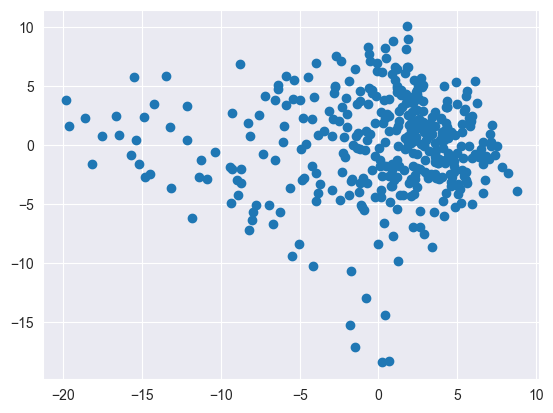

In [30]:
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_np)

fig, ax = plt.subplots()
ax.scatter(X_pca[:, 0], X_pca[:, 1])

In [56]:
from sklearn.model_selection import KFold

fold_data_test = []
fold_data_train = []
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, test_index) in enumerate(k_fold.split(X_np)):
    X_train, X_test = X_np[train_index], X_np[test_index]
    Y_train, Y_test = Y_np[train_index], Y_np[test_index]
    fold_data_test.append((X_test, Y_test))
    fold_data_train.append((X_train, Y_train))

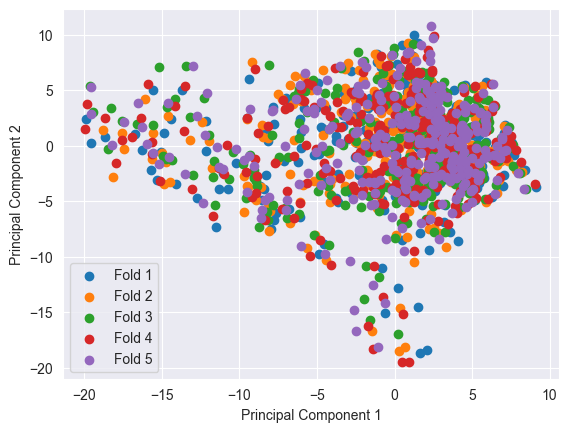

In [123]:
# Perform PCA on each fold's training data and visualize
for i, (train_data, test_data) in enumerate(fold_data_train):
    # Separate features and target variable
    X_train = train_data
    
    # Apply PCA
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    
    # Plot PCA results
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label=f'Fold {i+1}')
    
# plt.title("PCA Visualization of Training Data Across Folds")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

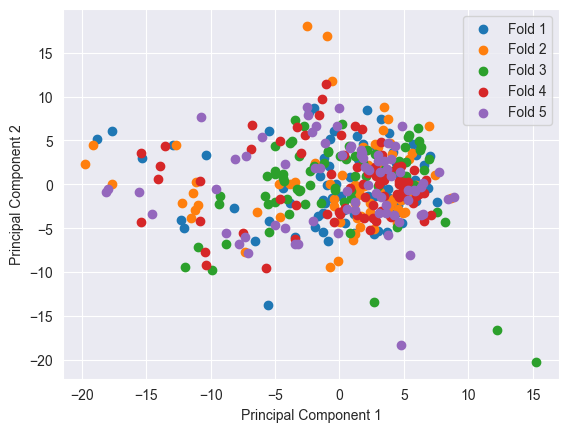

In [124]:
# Perform PCA on each fold's training data and visualize
for i, (train_data, test_data) in enumerate(fold_data_test):
    # Separate features and target variable
    X_train = train_data
    
    # Apply PCA
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    
    # Plot PCA results
    plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label=f'Fold {i+1}')
    
# plt.title("PCA Visualization of Testing Data Across Folds")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

In [127]:
from scipy.stats import ks_2samp

fold1_X, fold1_Y = fold_data_train[0]
fold2_X, fold2_Y = fold_data_train[1]
fold3_X, fold3_Y = fold_data_train[2]
fold4_X, fold4_Y = fold_data_train[3]
fold5_X, fold5_Y = fold_data_train[4]

In [72]:
# Loop through each feature (column in X_np)
num_features = fold1_X.shape[1]  # Number of features
ks_results = []

for feature_idx in range(num_features):
    stat, p_value = ks_2samp(fold1_X[:, feature_idx], fold4_X[:, feature_idx])
    ks_results.append((feature_idx, stat, p_value))

# Print results
for feature_idx, stat, p_value in ks_results:
    print(f"Feature {feature_idx}: K-S Statistic = {stat:.4f}, P-value = {p_value:.4f}")

Feature 0: K-S Statistic = 0.0461, P-value = 0.9046
Feature 1: K-S Statistic = 0.0526, P-value = 0.7946
Feature 2: K-S Statistic = 0.0296, P-value = 0.9994
Feature 3: K-S Statistic = 0.0296, P-value = 0.9994
Feature 4: K-S Statistic = 0.0428, P-value = 0.9444
Feature 5: K-S Statistic = 0.0230, P-value = 1.0000
Feature 6: K-S Statistic = 0.0329, P-value = 0.9967
Feature 7: K-S Statistic = 0.0592, P-value = 0.6618
Feature 8: K-S Statistic = 0.0296, P-value = 0.9994
Feature 9: K-S Statistic = 0.0428, P-value = 0.9444
Feature 10: K-S Statistic = 0.0230, P-value = 1.0000
Feature 11: K-S Statistic = 0.0329, P-value = 0.9967
Feature 12: K-S Statistic = 0.0296, P-value = 0.9994
Feature 13: K-S Statistic = 0.0362, P-value = 0.9888
Feature 14: K-S Statistic = 0.0230, P-value = 1.0000
Feature 15: K-S Statistic = 0.0230, P-value = 1.0000
Feature 16: K-S Statistic = 0.0329, P-value = 0.9967
Feature 17: K-S Statistic = 0.0296, P-value = 0.9994
Feature 18: K-S Statistic = 0.0230, P-value = 1.0000
Fea

/Users/shayreardon/Documents/Projects/pythonProject1/.venv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


In [110]:
from itertools import combinations

# Compare all pairs of folds
num_folds = len(fold_data_train)
all_fold_combinations = combinations(range(num_folds), 2)

for fold_a, fold_b in all_fold_combinations:
    fold_a_X, _ = fold_data_train[fold_a]
    fold_b_X, _ = fold_data_train[fold_b]
    
    print(f"Comparing Fold {fold_a + 1} vs. Fold {fold_b + 1}")
    
    for feature_idx in range(num_features):
        stat, p_value = ks_2samp(fold_a_X[:, feature_idx], fold_b_X[:, feature_idx])
        # print(f"Feature {feature_idx}: K-S Statistic = {stat:.4f}, P-value = {p_value:.4f}")

Comparing Fold 1 vs. Fold 2
Comparing Fold 1 vs. Fold 3


/Users/shayreardon/Documents/Projects/pythonProject1/.venv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


Comparing Fold 1 vs. Fold 4
Comparing Fold 1 vs. Fold 5
Comparing Fold 2 vs. Fold 3
Comparing Fold 2 vs. Fold 4
Comparing Fold 2 vs. Fold 5
Comparing Fold 3 vs. Fold 4
Comparing Fold 3 vs. Fold 5
Comparing Fold 4 vs. Fold 5


In [128]:
# Initialize an array to store K-S statistics (num_features x num_folds x num_folds)
num_features = fold_data_train[0][0].shape[1]
num_folds = len(fold_data_train)
ks_matrix = np.zeros((num_features, num_folds, num_folds))
p_matrix = np.zeros((num_features, num_folds, num_folds))


# Compute K-S statistic for each pair of folds and each feature
from scipy.stats import ks_2samp

for feature_idx in range(num_features):
    for i in range(num_folds):
        for j in range(num_folds):
            if i != j:  # Skip diagonal comparisons
                stat, p = ks_2samp(
                    fold_data_train[i][0][:, feature_idx], 
                    fold_data_train[j][0][:, feature_idx]
                )
                ks_matrix[feature_idx, i, j] = stat
                p_matrix[feature_idx, i, j] = p


/Users/shayreardon/Documents/Projects/pythonProject1/.venv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


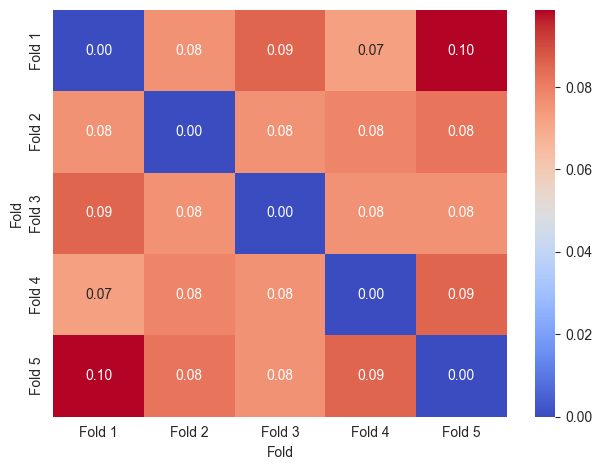

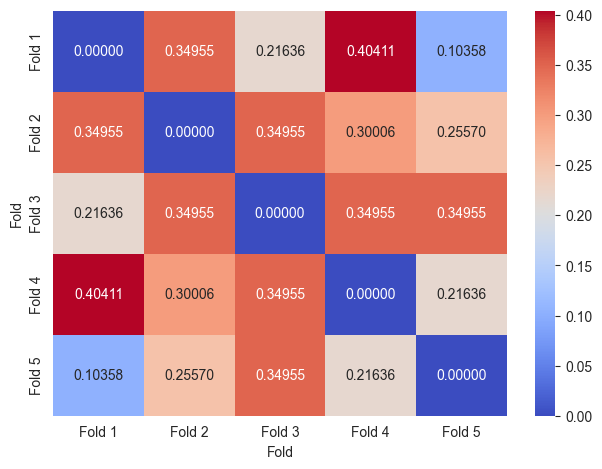

In [129]:
fold_to_fold_summary = ks_matrix.max(axis=0)  # Max across features

sns.heatmap(fold_to_fold_summary, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=[f'Fold {i+1}' for i in range(num_folds)],
            yticklabels=[f'Fold {i+1}' for i in range(num_folds)])
# plt.title("K-S Statistics Heatmap Across Test Folds (Mean Over Features)")
plt.xlabel("Fold")
plt.ylabel("Fold")
plt.tight_layout()
plt.show()

matching_p_values = np.zeros((num_folds, num_folds))

# Find maximum K-S statistics and corresponding p-values
for i in range(num_folds):
    for j in range(num_folds):
        if i != j:  # Skip diagonal comparisons
            # Find the feature index with the maximum K-S statistic for this fold combination
            max_feature_idx = np.argmax(ks_matrix[:, i, j])
            # Retrieve the corresponding p-value
            matching_p_values[i, j] = p_matrix[max_feature_idx, i, j]

sns.heatmap(matching_p_values, annot=True, cmap="coolwarm", fmt=".5f",
            xticklabels=[f'Fold {i+1}' for i in range(num_folds)],
            yticklabels=[f'Fold {i+1}' for i in range(num_folds)])
# plt.title("K-S Statistics Heatmap Across Test Folds (Mean Over Features)")
plt.xlabel("Fold")
plt.ylabel("Fold")
plt.tight_layout()
plt.show()

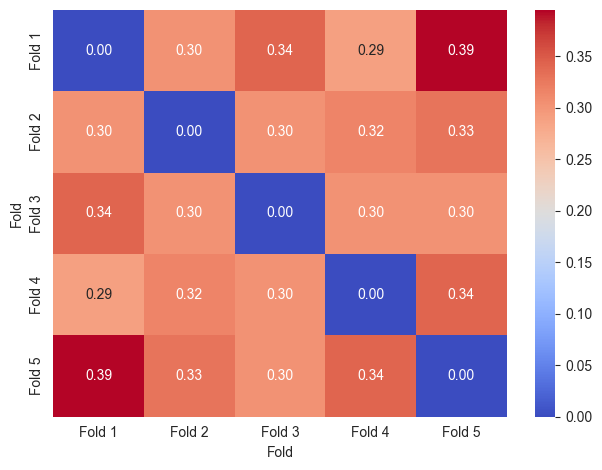

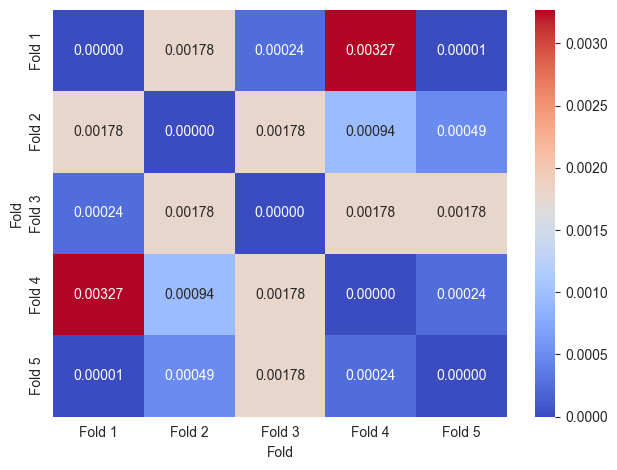

In [131]:
# Initialize an array to store K-S statistics (num_features x num_folds x num_folds)
num_features = fold_data_test[0][0].shape[1]
num_folds = len(fold_data_test)
ks1_matrix = np.zeros((num_features, num_folds, num_folds))
p1_matrix = np.zeros((num_features, num_folds, num_folds))


# Compute K-S statistic for each pair of folds and each feature
from scipy.stats import ks_2samp

for feature_idx in range(num_features):
    for i in range(num_folds):
        for j in range(num_folds):
            if i != j:  # Skip diagonal comparisons
                stat, p = ks_2samp(
                    fold_data_test[i][0][:, feature_idx], 
                    fold_data_test[j][0][:, feature_idx]
                )
                ks1_matrix[feature_idx, i, j] = stat
                p1_matrix[feature_idx, i, j] = p

fold_to_fold_summary1 = ks1_matrix.max(axis=0)  # Max across features

sns.heatmap(fold_to_fold_summary1, annot=True, cmap="coolwarm", fmt=".2f",
            xticklabels=[f'Fold {i+1}' for i in range(num_folds)],
            yticklabels=[f'Fold {i+1}' for i in range(num_folds)])
# plt.title("K-S Statistics Heatmap Across Test Folds (Mean Over Features)")
plt.xlabel("Fold")
plt.ylabel("Fold")
plt.tight_layout()
plt.show()

matching_p_values1 = np.zeros((num_folds, num_folds))

# Find maximum K-S statistics and corresponding p-values
for i in range(num_folds):
    for j in range(num_folds):
        if i != j:  # Skip diagonal comparisons
            # Find the feature index with the maximum K-S statistic for this fold combination
            max_feature_idx = np.argmax(ks_matrix[:, i, j])
            # Retrieve the corresponding p-value
            matching_p_values1[i, j] = p1_matrix[max_feature_idx, i, j]

sns.heatmap(matching_p_values1, annot=True, cmap="coolwarm", fmt=".5f",
            xticklabels=[f'Fold {i+1}' for i in range(num_folds)],
            yticklabels=[f'Fold {i+1}' for i in range(num_folds)])
# plt.title("K-S Statistics Heatmap Across Test Folds (Mean Over Features)")
plt.xlabel("Fold")
plt.ylabel("Fold")
plt.tight_layout()
plt.show()